# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
from IPython.display import display, HTML

warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.base import clone

from catboost import CatBoostClassifier, Pool

# Load Data

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
orig_df = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

In [3]:
train_df = pd.concat([train_df, orig_df])
train_df = train_df.reset_index(drop=True)

In [4]:
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


## Removing Duplicate Data

In [6]:
train_df.duplicated().sum()

165

In [7]:
train_df.drop_duplicates(inplace=True)

## Handling Missing Values

In [8]:
train_df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [9]:
train_df[['loan_int_rate','person_emp_length']].describe()

,loan_int_rate,person_emp_length
count,87966.000000,90174.000000
mean,10.791001,4.732306
std,3.109323,4.025893
min,5.420000,0.000000
25%,7.880000,2.000000
50%,10.950000,4.000000
75%,13.110000,7.000000
max,23.220000,123.000000


In [10]:
train_df['loan_int_rate'] = train_df['loan_int_rate'].fillna(train_df['loan_int_rate'].median())
train_df['person_emp_length'] = train_df['person_emp_length'].fillna(train_df['person_emp_length'].median())

# EDA

In [11]:
target = 'loan_status'

In [12]:
features = train_df.drop(target, axis=1).columns.tolist()

In [13]:
categorical_features = train_df.select_dtypes(include='object').columns.tolist()

In [14]:
numerical_features = list(set(features) - set(categorical_features))

In [15]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,91061.0,27.620683,6.150047,20.00,23.00,26.00,30.00,144.00
person_income,91061.0,64774.320917,47922.855155,4000.00,40000.00,57000.00,78000.00,6000000.00
person_emp_length,91061.0,4.725173,4.006883,0.00,2.00,4.00,7.00,123.00
loan_amnt,91061.0,9351.508352,5848.017127,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,91061.0,10.796405,3.056161,5.42,7.88,10.95,13.04,23.22
loan_percent_income,91061.0,0.163158,0.097486,0.00,0.09,0.14,0.22,0.83
cb_person_cred_hist_length,91061.0,5.812752,4.039820,2.00,3.00,4.00,8.00,30.00
loan_status,91061.0,0.169546,0.375235,0.00,0.00,0.00,0.00,1.00


In [16]:
train_df[categorical_features].describe(include='O').T

,count,unique,top,freq
person_home_ownership,91061,4,RENT,46972
loan_intent,91061,6,EDUCATION,18682
loan_grade,91061,7,A,31687
cb_person_default_on_file,91061,2,N,76629


In [17]:
for col in categorical_features:
    display(train_df.groupby(col)[['loan_amnt', 'loan_int_rate']].agg(['min', 'mean', 'max']))

loan_amnt                      loan_int_rate             \
                            min          mean    max           min       mean   
person_home_ownership                                                           
MORTGAGE                    500  10179.788836  35000          5.42  10.162017   
OTHER                      1000  10571.923077  25000          5.79  11.743487   
OWN                         900   8871.105946  35000          5.42  10.781526   
RENT                        500   8731.272396  35000          5.42  11.310101   

                              
                         max  
person_home_ownership         
MORTGAGE               22.48  
OTHER                  20.52  
OWN                    21.27  
RENT                   23.22

loan_amnt                      loan_int_rate             \
                        min          mean    max           min       mean   
loan_intent                                                                 
DEBTCONSOLIDATION       500   9315.149770  35000          5.42  10.748191   
EDUCATION               700   9198.682261  35000          5.42  10.775112   
HOMEIMPROVEMENT         500  10274.280433  35000          5.42  10.992674   
MEDICAL                 500   8980.716894  35000          5.42  10.853199   
PERSONAL                500   9360.252030  35000          5.42  10.745993   
VENTURE                 500   9378.480851  35000          5.42  10.730663   

                          
                     max  
loan_intent               
DEBTCONSOLIDATION  22.11  
EDUCATION          21.74  
HOMEIMPROVEMENT    23.22  
MEDICAL            21.74  
PERSONAL           22.06  
VENTURE            23.22

loan_amnt                      loan_int_rate                  
                 min          mean    max           min       mean    max
loan_grade                                                               
A                500   8480.407580  35000          5.42   7.446044  19.04
B                500   9747.230389  35000          5.99  11.020022  17.56
C                500   9087.000687  35000          5.79  13.402966  16.29
D               1000  10661.303443  35000          6.00  15.227727  19.13
E               1000  12539.439655  35000          6.00  16.713788  23.06
F               1200  13997.756410  35000         10.95  18.079590  22.06
G               1500  15618.298969  35000         10.95  19.797938  23.22

loan_amnt                     loan_int_rate  \
                                min         mean    max           min   
cb_person_default_on_file                                               
N                               500  9277.775803  35000          5.42   
Y                               750  9743.003049  35000          5.99   

                                             
                                mean    max  
cb_person_default_on_file                    
N                          10.142169  21.74  
Y                          14.270177  23.22

# Feature Distribution

In [18]:
def feature_distribution_plot(df, col, target_col=None):
    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    if df[col].dtype != 'object':
        sns.histplot(data=df, x=col, hue=target_col)
    else:
        sns.countplot(data=df, x=col, hue=target_col)
    plt.ylabel('Count')
    plt.xlabel(f'{col}')
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1,2,2)
    if df[col].dtype != 'object':
        sns.boxplot(data=df, x=col, hue=target_col)
        plt.title(f'Boxplot of {col}')
        plt.ylabel('Count')
        plt.xlabel(f'{col}')
    else:
        df[col].value_counts().plot(kind='pie', autopct='%.0f%%',pctdistance=0.85,fontsize=12)
        plt.gca().add_artist(plt.Circle((0,0),radius=0.7,fc='white'))
        plt.title(f'Pie Chart of {col}')
        plt.xlabel('')
        plt.ylabel('')
    
    
    plt.tight_layout()
    plt.suptitle(f'Distribution of {col}', y=1.05, size=24, weight='bold')
    plt.show()

## Distribution of Numerical Features

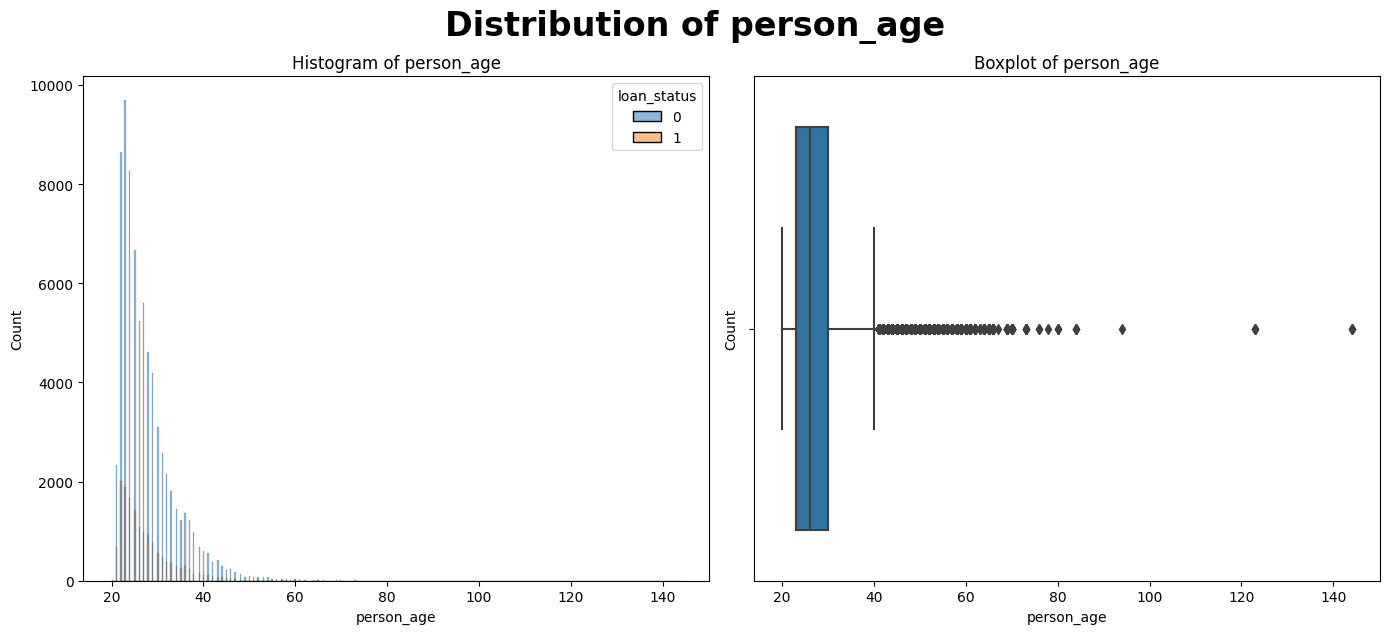

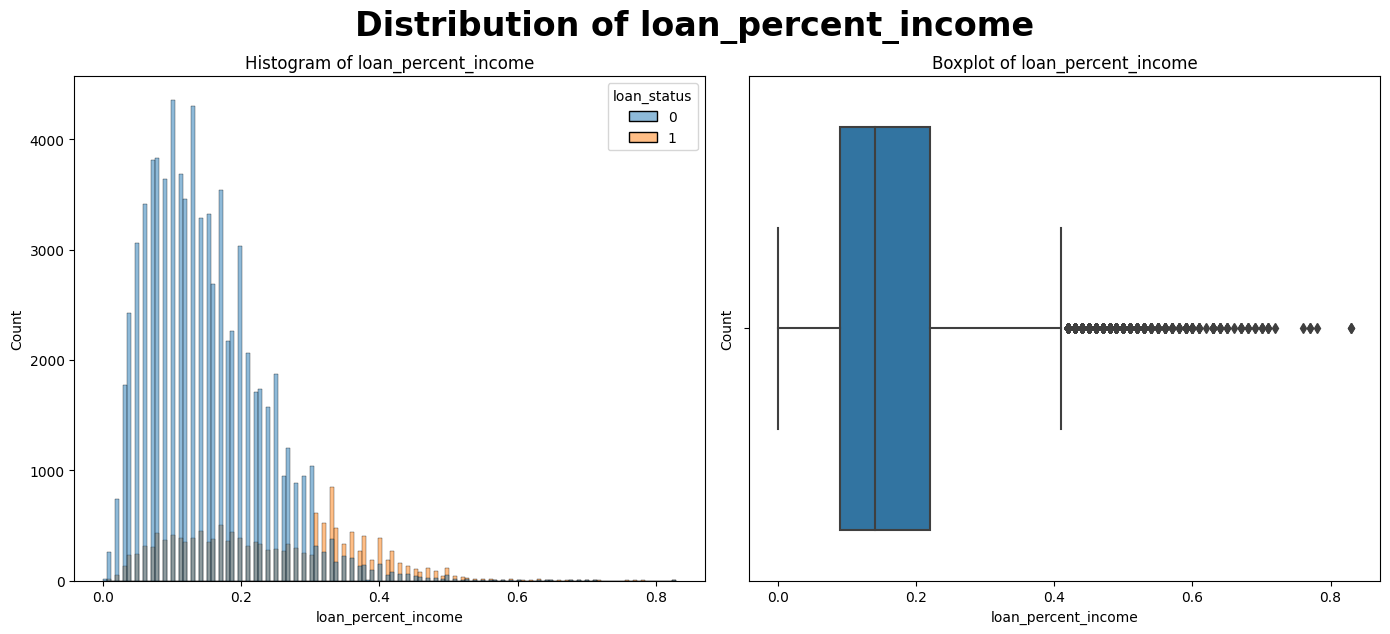

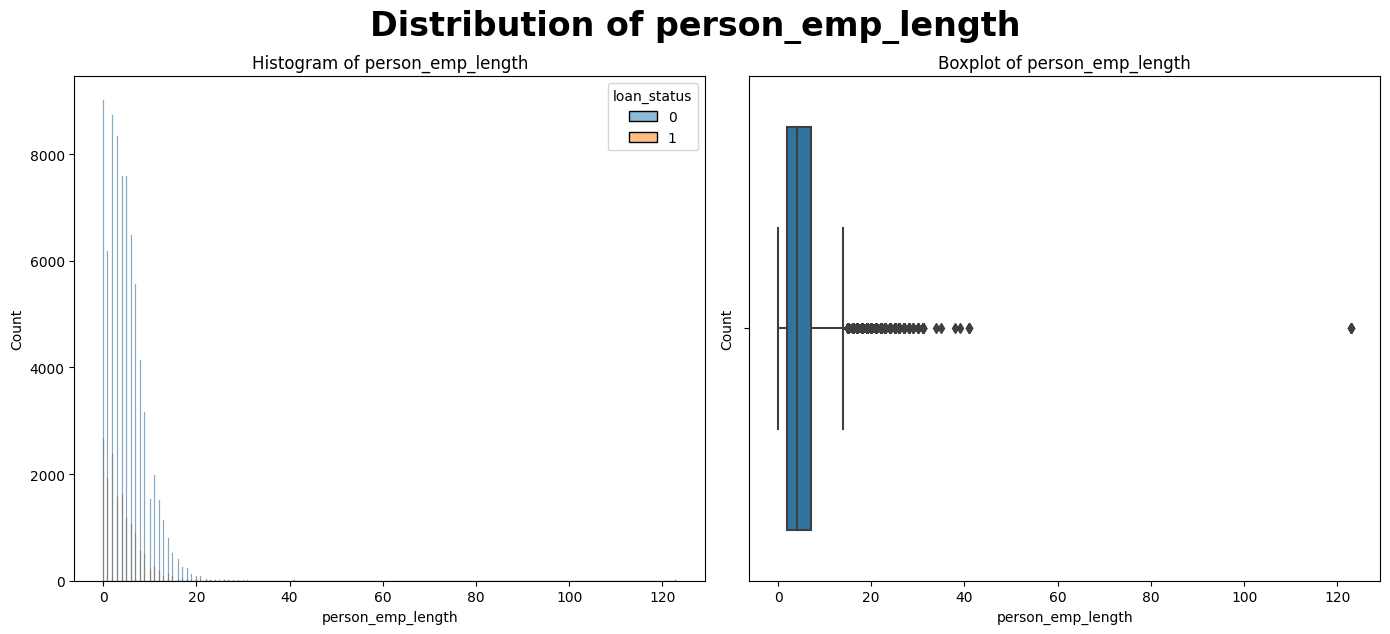

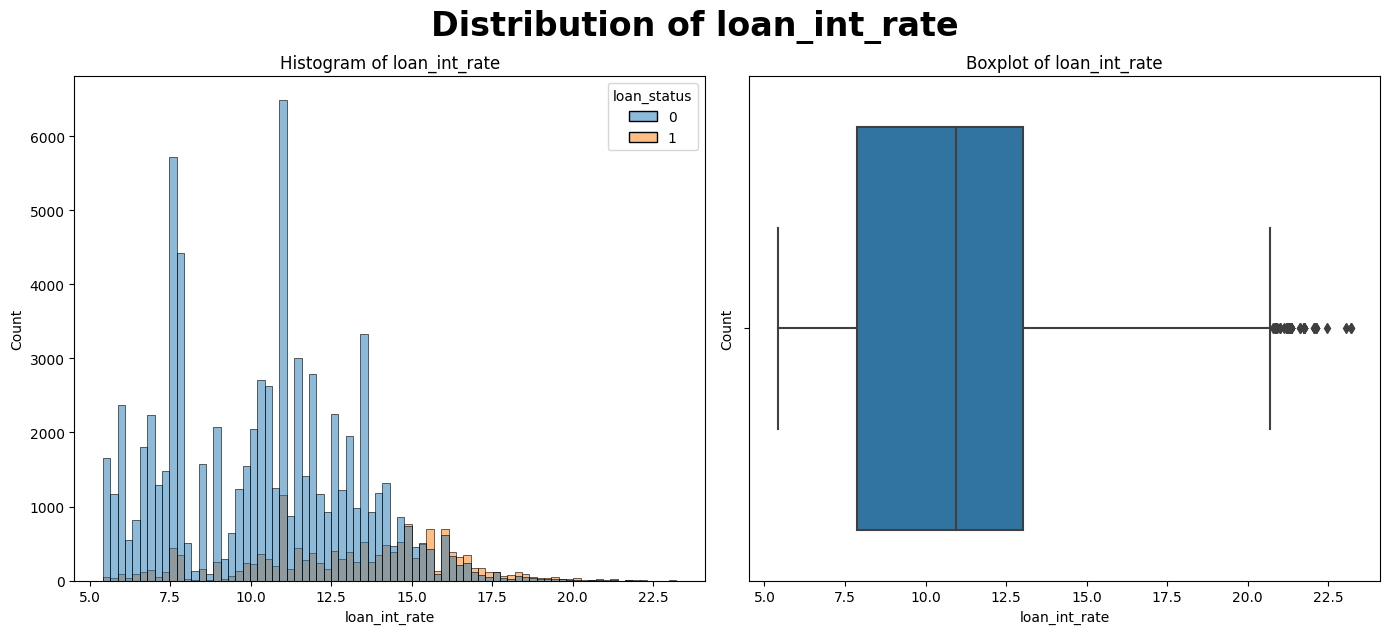

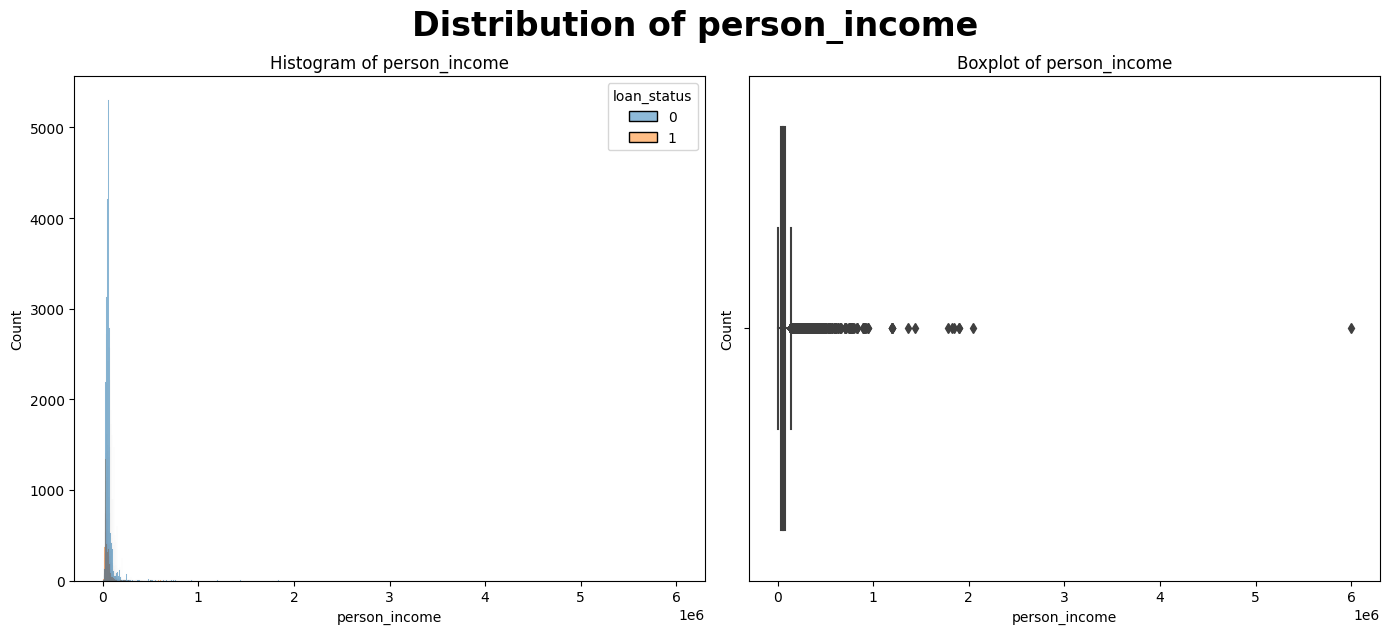

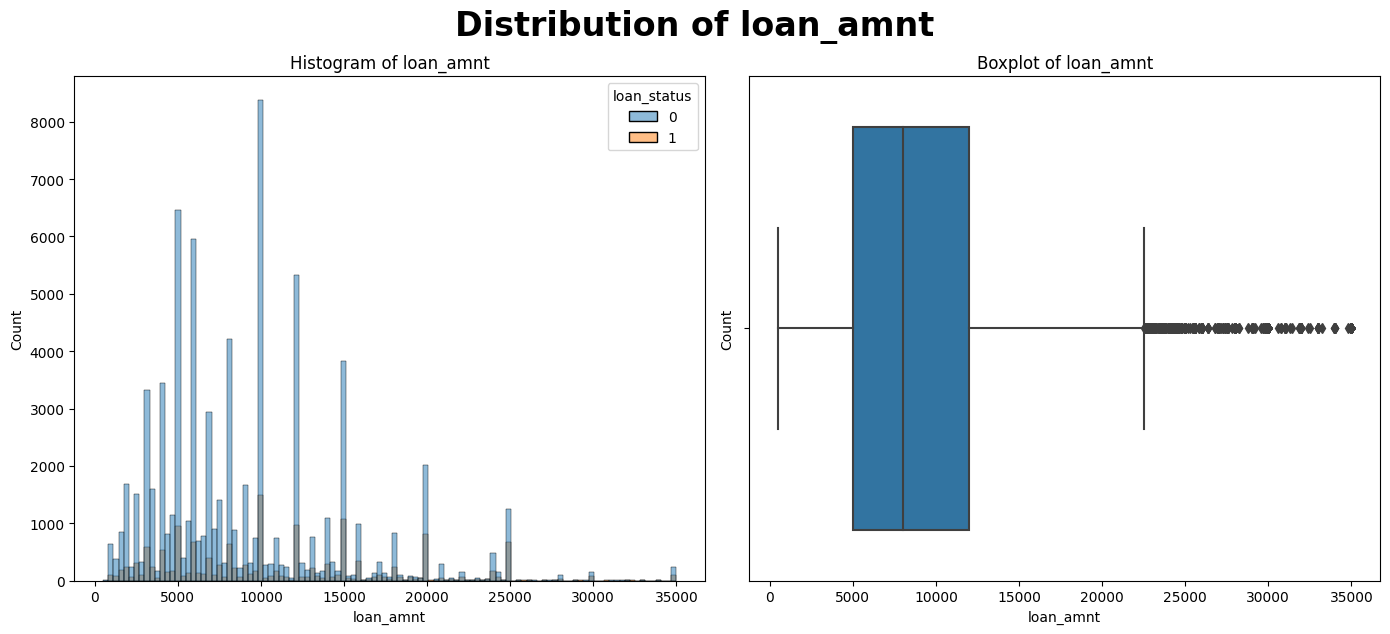

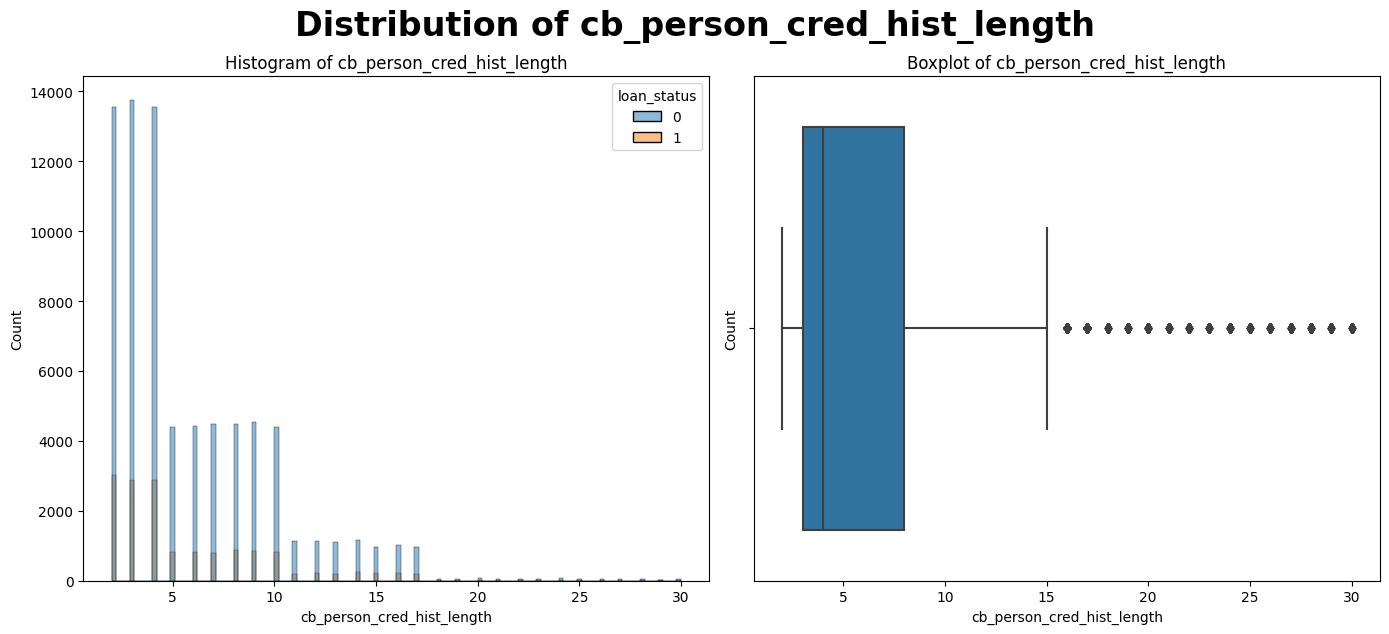

In [19]:
for col in numerical_features:
    feature_distribution_plot(train_df, col, target)

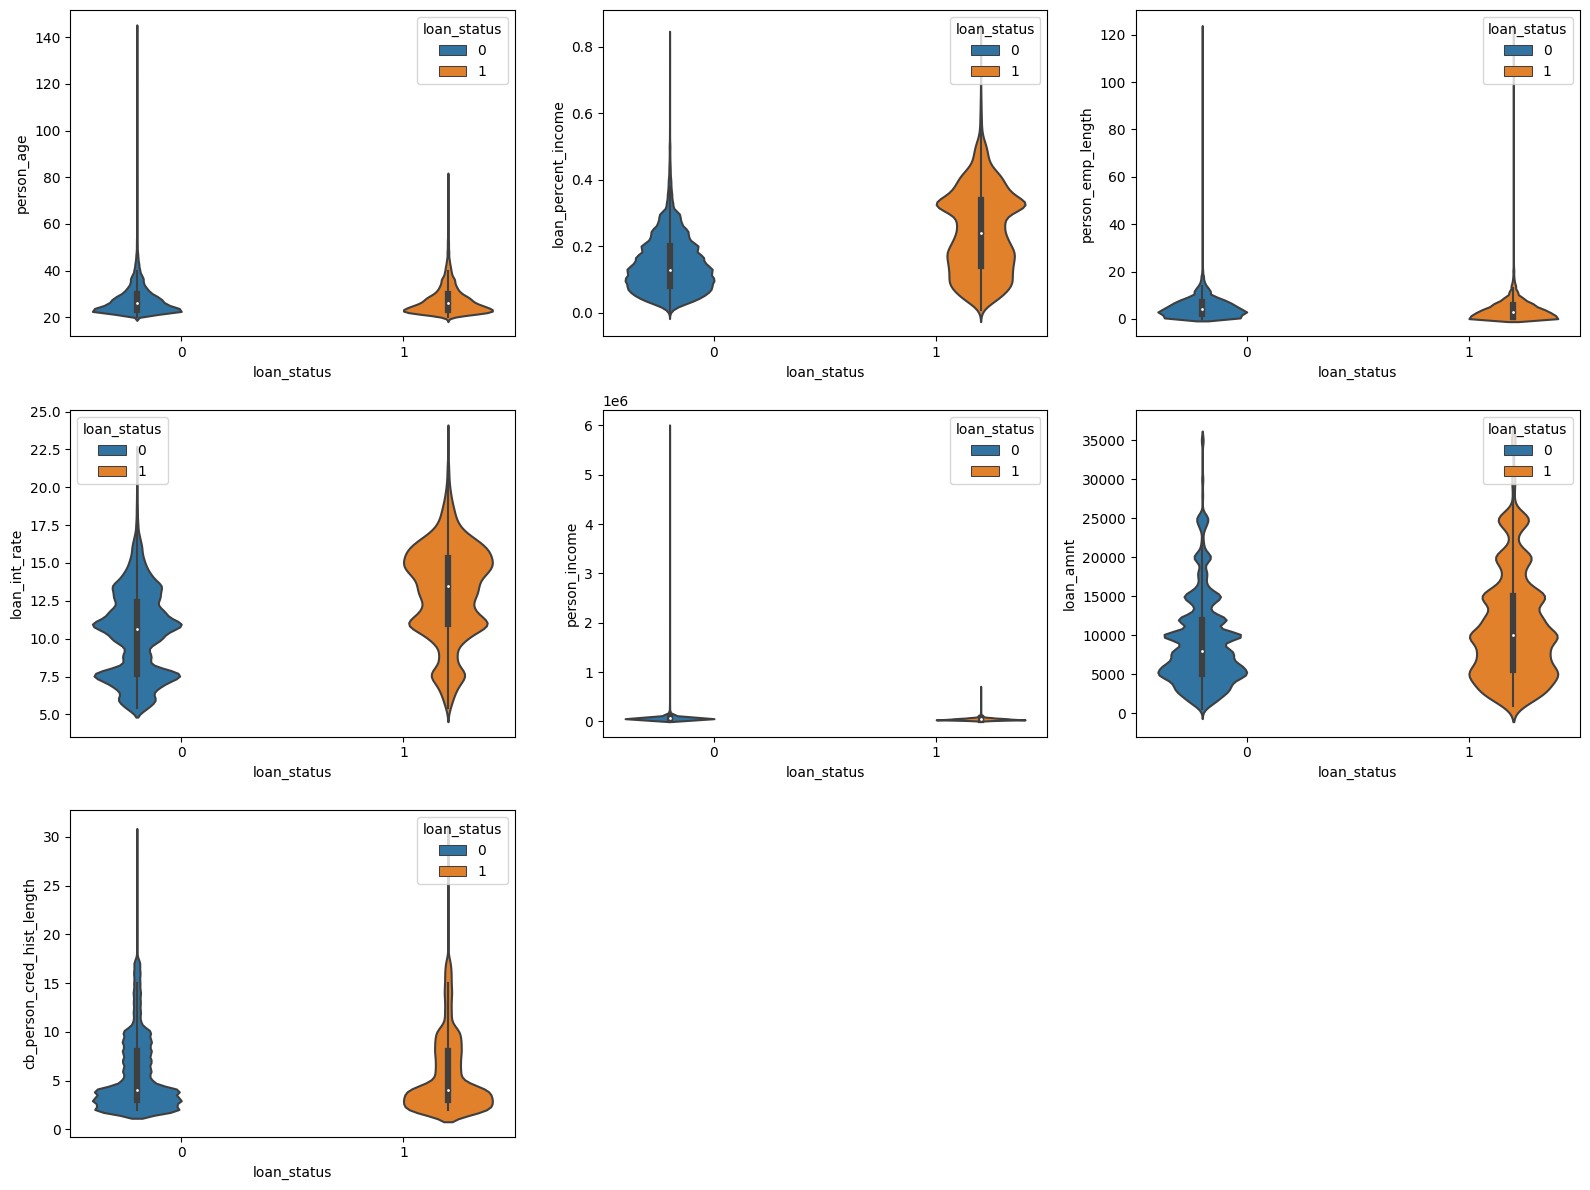

In [20]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.violinplot(train_df, x=target, y=col, hue=target, legend=None)

plt.tight_layout()
plt.show()

## Distribution of Categorical Features

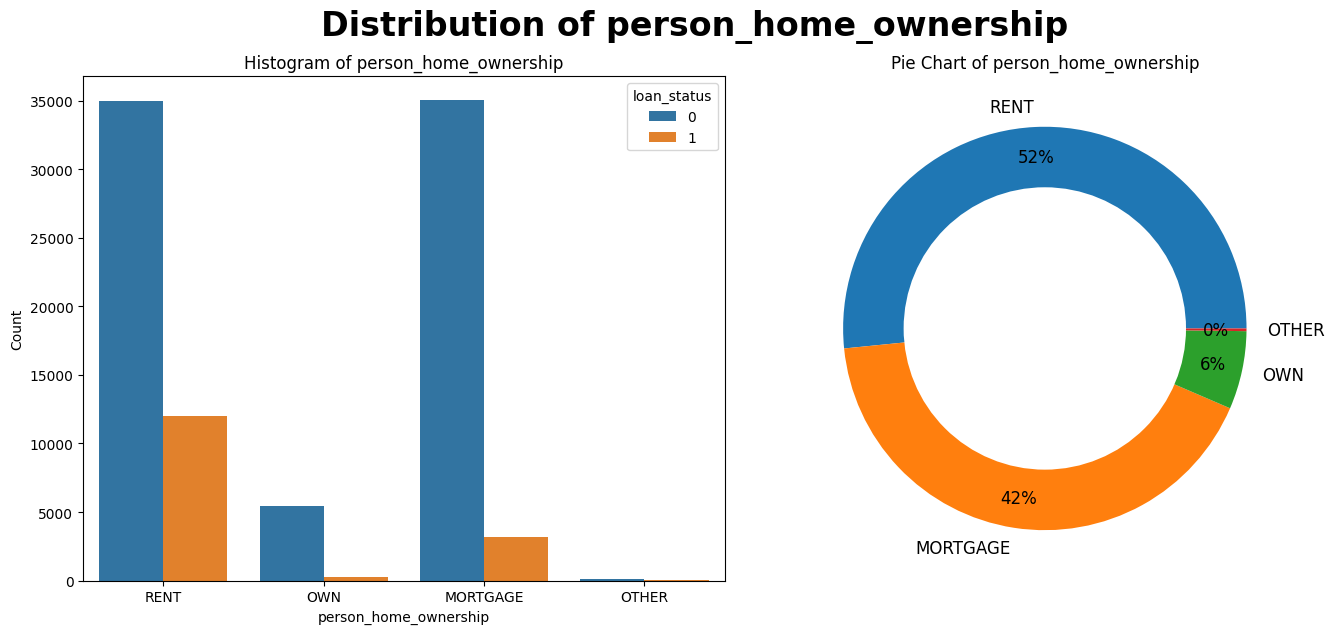

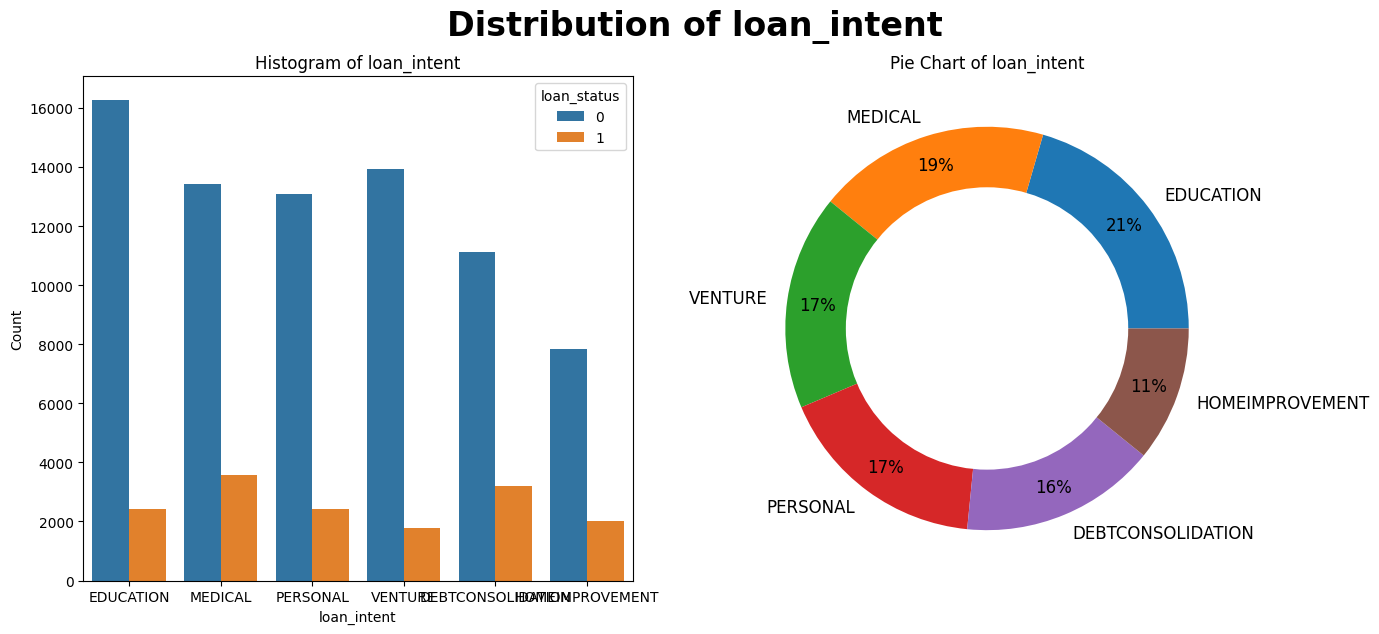

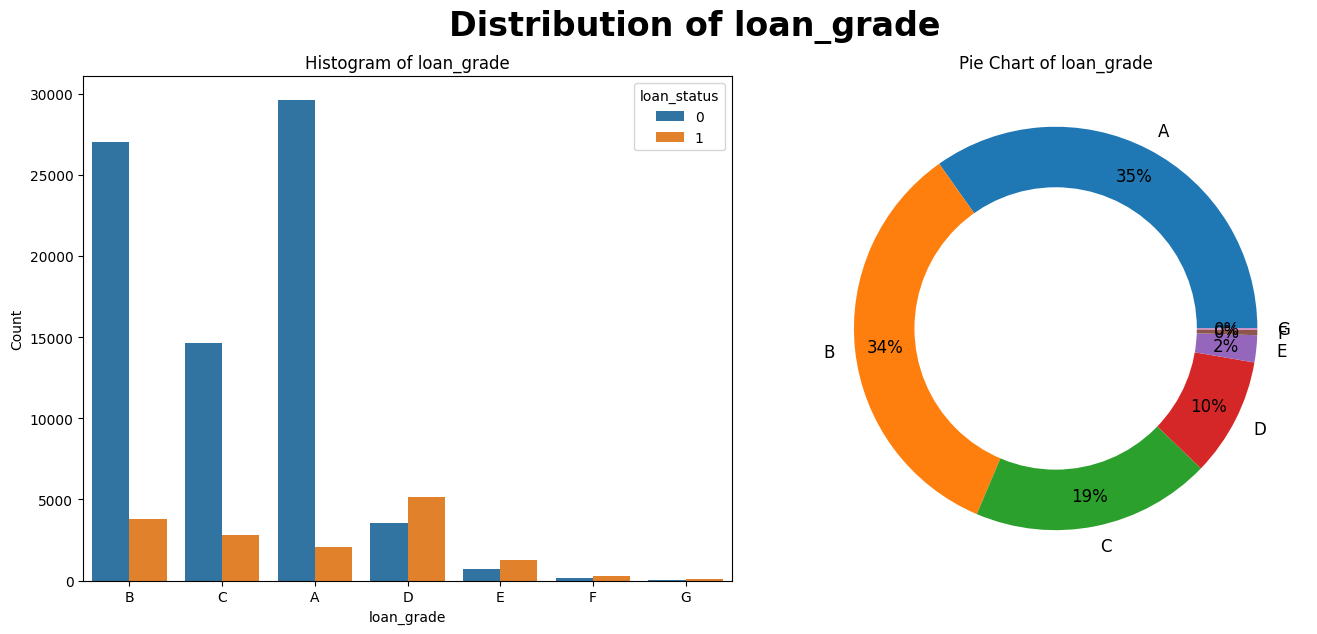

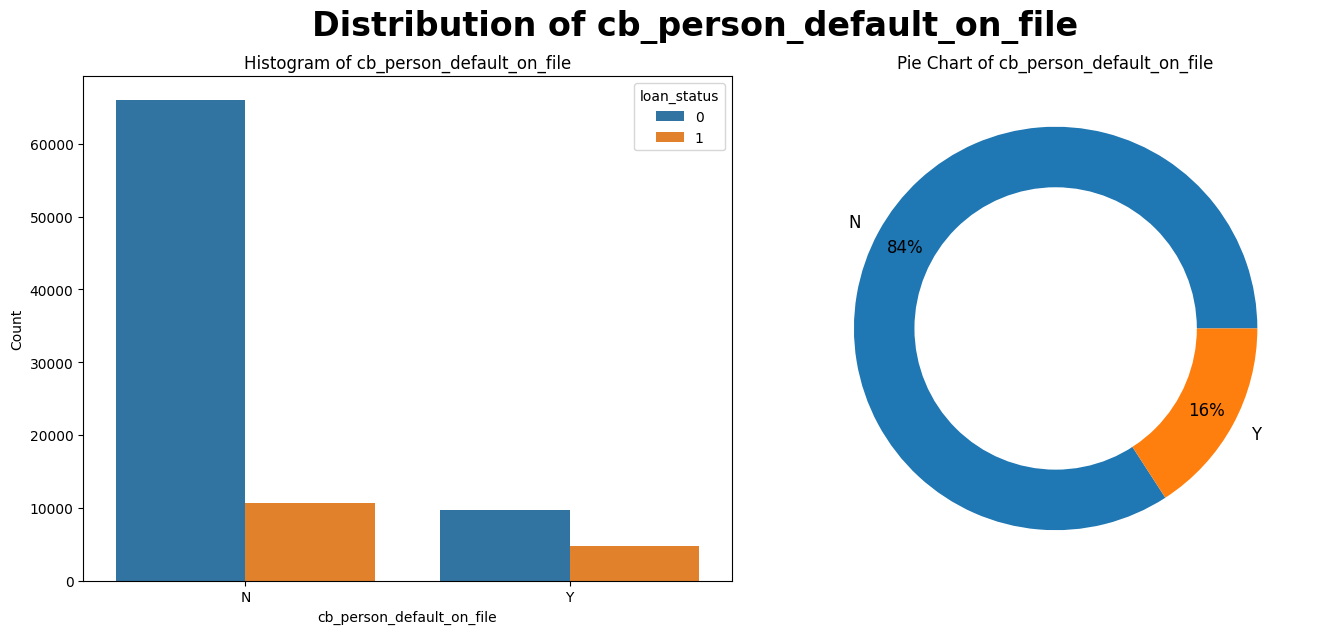

In [21]:
for col in categorical_features:
    feature_distribution_plot(train_df, col, target)

## Target Distribution

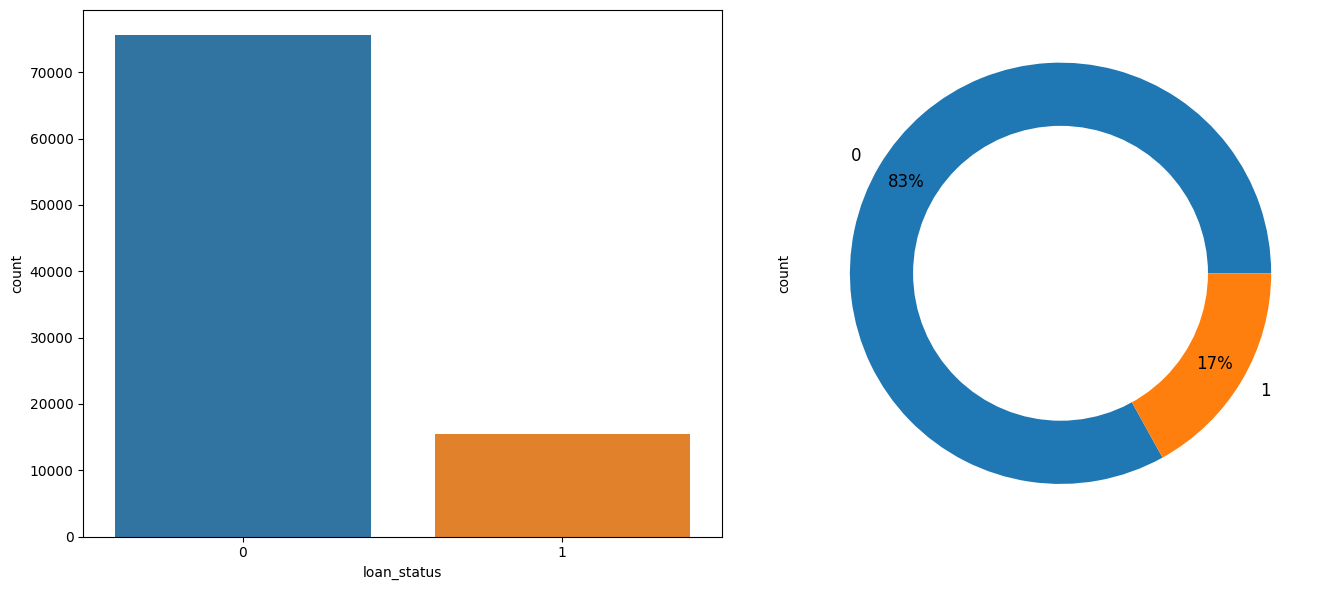

In [22]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.countplot(train_df, x=target)

plt.subplot(1,2,2)
train_df[target].value_counts().plot.pie(autopct='%.0f%%',pctdistance=0.85,fontsize=12)
plt.gca().add_artist(plt.Circle((0,0),radius=0.7,fc='white'))

plt.tight_layout()
plt.show()

## Correlation Matrix

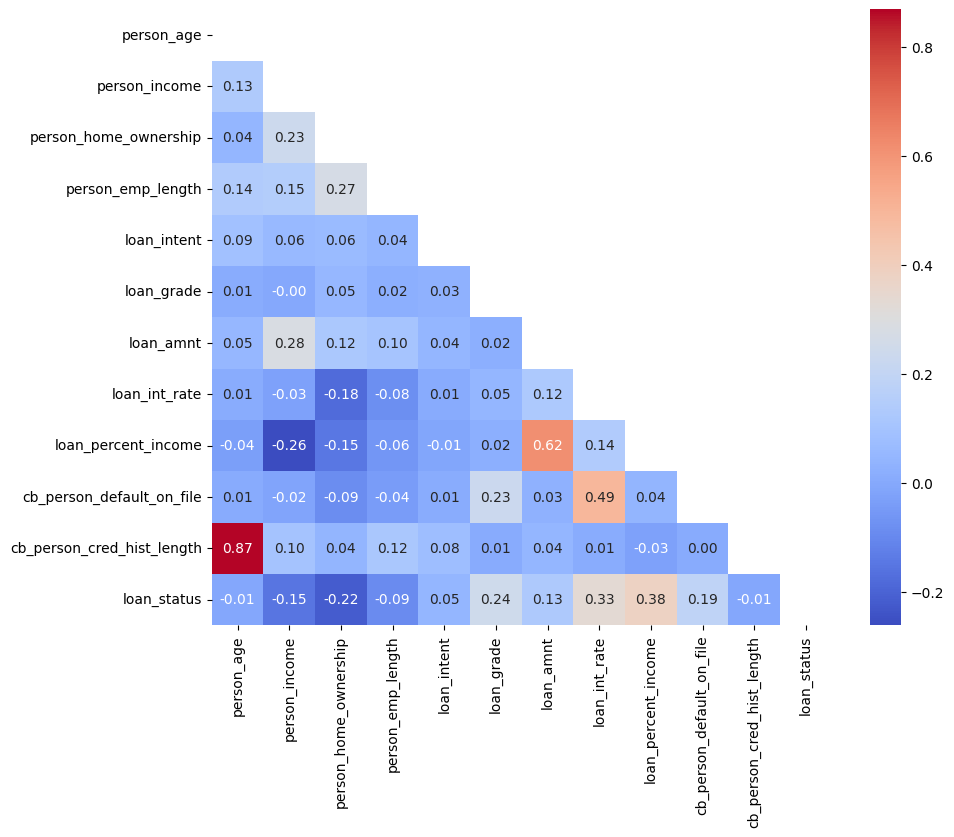

In [23]:
train_new = train_df.copy()

for col in categorical_features:
    train_new[col], _ = train_new[col].factorize()

cor_mat = train_new.corr()
mask = np.triu(cor_mat)

plt.figure(figsize=(10, 8))
sns.heatmap(cor_mat, fmt='.2f', annot=True, mask=mask, cmap='coolwarm')
plt.show()

# Model Training And Prediction

In [24]:
def convert_to_string(df):
    df_cat = df.copy()
    df_cat = df_cat.fillna(0)
    for col in features:
        df_cat[col] = df_cat[col].astype('string')
    return df_cat

In [25]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)

In [26]:
X = train_df.drop(target, axis=1)
y = train_df[target].ravel()

In [27]:
oof_preds = []
oof_aucs = []
oof_train_preds = np.zeros(len(y))

cat_params={
    'task_type'           : "CPU",
    'loss_function'       : 'Logloss',
    'eval_metric'         : "AUC",
    'bagging_temperature' : 0.25,
    'colsample_bylevel'   : 0.40,
    'iterations'          : 5_000,
    'learning_rate'       : 0.045,
    'max_depth'           : 7,
    'l2_leaf_reg'         : 0.80,
    'min_data_in_leaf'    : 30,
    'random_strength'     : 0.25,
    'random_state'        : 42,
    'early_stopping_rounds': 20,
    'use_best_model'       : True,
    'allow_writing_files' : False,
} 

X_cat = convert_to_string(X)
test_cat = convert_to_string(test_df)

test_pool = Pool(test_cat, cat_features=features)

for fold, (train_idx, test_idx) in enumerate(skfold.split(X_cat, y)):
    X_train, y_train = X_cat.iloc[train_idx], y[train_idx]
    X_test, y_test = X_cat.iloc[test_idx], y[test_idx]
    
    X_train_pool = Pool(X_train, y_train, cat_features=features)
    X_test_pool = Pool(X_test, y_test, cat_features=features)
    
    cat_clf = CatBoostClassifier(**cat_params)
    cat_clf = cat_clf.fit(X=X_train_pool,
                          eval_set=X_test_pool,
                          verbose=500,
                          early_stopping_rounds=20)
    oof_train_preds[test_idx] = cat_clf.predict_proba(Pool(X_test, cat_features=features))[:, 1]
    test_pred = cat_clf.predict_proba(test_pool)[:, 1]
    
    oof_preds.append(test_pred)
    auc = roc_auc_score(y_test, oof_train_preds[test_idx])
    oof_aucs.append(auc)
    print(f"\nFold {fold+1}--> ROC-AUC Score: {auc:.6f}\n")
    
    del X_train, y_train, X_test, y_test
    del X_train_pool, X_test_pool
    del cat_clf
    gc.collect()

auc_mean = np.mean(oof_aucs)
auc_std = np.std(oof_aucs)
print(f"\nAverage Fold ROC-AUC Score: {auc_mean:.6f} \xB1 {auc_std:.6f}\n")


test_pred_cat = np.mean(oof_preds, axis=0)

0:	test: 0.8856384	best: 0.8856384 (0)	total: 169ms	remaining: 14m 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9625594916
bestIteration = 478

Shrink model to first 479 iterations.

Fold 1--> ROC-AUC Score: 0.962559

0:	test: 0.8926000	best: 0.8926000 (0)	total: 97.3ms	remaining: 8m 6s
500:	test: 0.9710088	best: 0.9710124 (498)	total: 48.4s	remaining: 7m 14s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9714741816
bestIteration = 730

Shrink model to first 731 iterations.

Fold 2--> ROC-AUC Score: 0.971474

0:	test: 0.8722285	best: 0.8722285 (0)	total: 98.1ms	remaining: 8m 10s
500:	test: 0.9652635	best: 0.9652769 (497)	total: 47.8s	remaining: 7m 9s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9664809766
bestIteration = 897

Shrink model to first 898 iterations.

Fold 3--> ROC-AUC Score: 0.966481

0:	test: 0.8808523	best: 0.8808523 (0)	total: 92.4ms	remaining: 7m 41s
500:	test: 0.9654173	best: 0.9654206 (485)	total:

# Submission

In [28]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [29]:
ext1 = pd.read_csv("/kaggle/input/boosting-synergy-six-model-blend-for-loan-predict/submission.csv")[target].ravel()
ext2 = pd.read_csv("/kaggle/input/ps4e10-yunbase/ensemble.csv.csv")[target].ravel()
ext3 = pd.read_csv("/kaggle/input/ps-s4-e10-ensemble-of-solutions/submission.csv")[target].ravel()

In [30]:
res = np.average([ext1, ext2, ext3, test_pred_cat], weights=[11, 3, 5, 1], axis=0)

In [31]:
sub[target] = res
sub.to_csv('submission.csv', index=False)